In [1]:
import numpy as np
import scipy.io as scio
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os
import skimage
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set()
from sklearn import metrics

C:\Users\jpienkny\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [8]:
HR_Distance = np.genfromtxt("HR_Distances.csv", delimiter=",")
EDA_Distance = np.genfromtxt("EDA_Distances.csv", delimiter=",")


HR_Distance_Windows_extract = np.genfromtxt("HR_Distances_Windows.csv", delimiter=",")
EDA_Distance_Windows_extract = np.genfromtxt("EDA_Distances_Windows.csv", delimiter=",")
HR_Distance_Windows = np.empty((15,73,73))
EDA_Distance_Windows = np.empty((15,73,73))
ms_interval_labels = np.genfromtxt("MS_Interval_Labels.csv", delimiter=",")
ms_end_labels = np.genfromtxt("MS_EndLabels.csv", delimiter=",")






for i in range(15):
    HR_Distance_Windows[i,:,:] = HR_Distance_Windows_extract[:,73*i:73*(i+1)]
    EDA_Distance_Windows[i,:,:] = EDA_Distance_Windows_extract[:,73*i:73*(i+1)]
    
    

In [9]:
HR_Distance.shape

(73, 73)

In [3]:
# Soft Threshold function (With 1/2 added)
def soft2(z, lam):     
    return 0.5*(np.sign(z)*np.maximum(np.abs(z)-lam,0)) 

In [4]:
# Soft Threshold function (From HW)
def soft(z, lam):     
    return np.sign(z)*np.maximum(np.abs(z)-lam,0) 

In [5]:
#Implementation of Alternating Method
def DL(Y, X0, lam, fun = lambda z:0, niter=1000, eps=1e-4): 
    '''
    Input:
        Y:     Observation Matrix
        X0:    intilalization 
        lam:   regularization parameter
        fun:   user defined function (e.g objective function)
        niter: maximum umber of iterations
        eps:   termination crtieria 
        
    Output: 
        A:     (Unitary) Dictionary Matrix 
        X:     Representation Matrix
        out:   objective value at termination 
    '''
    X = X0.copy()
    out_prev = 1e4
    for itr in range(niter):
        U,_,V = np.linalg.svd(Y@X.T,full_matrices=False)
        A = U@V
        X = soft(A.T@Y, lam)
        out = fun(A,X, Y)
        if np.abs(out-out_prev)/np.abs(out_prev)<eps:
           break 
        out_prev = out
    return A, X, out 

In [6]:
#Implementation of Alternating Method for double dictionary learning
def DL_2(E, H,  X0, lam, fun = lambda z:0, niter=1000, eps=1e-3): 
    '''
    Input:
        E:     EDA Observation Matrix
        H:     HR Obseration Matrix
        X0:    intilalization 
        lam:   regularization parameter
        fun:   user defined function (e.g objective function)
        niter: maximum umber of iterations
        eps:   termination crtieria 
        
    Intermediate:
        Z = AH.T *H + AE.T * E
    Output: 
        AE:     (Unitary) Dictionary Matrix for EDA
        AH:     (Unitary) Dictionary Matrix for HR
        X:     Representation Matrix
        out:   objective value at termination 
    '''
    X = X0.copy()
    out_prev = 1e4
    for itr in range(niter):
        UE,_,VE = np.linalg.svd(E@X.T,full_matrices=False)
        AE = UE@VE
        UH,_,VH = np.linalg.svd(H@X.T,full_matrices=False)
        AH = UH@VH
        
        Z = AH.T @ H + AE.T @ E
        X = soft2(Z, lam)
        out = fun(AE,AH, X)
        print(np.abs(out-out_prev)/np.abs(out_prev))
        if np.abs(out-out_prev)/np.abs(out_prev)<eps:
           break 
        out_prev = out
    return AE, AH, X, out 

In [7]:
def LoCo(Ux, Uy):
    USx, _, _ = np.linalg.svd(Ux, full_matrices=True)
    USy, _, _ = np.linalg.svd(Uy, full_matrices = True)
    return .5 * np.linalg.norm(Ux.T @ USy[:,1], ord = 2) + .5 * np.linalg.norm(Uy.T @ USx[:,1], ord = 2)

def FOTS(Ux, Uy):
    return np.linalg.norm(Ux - Uy, ord='fro')

In [12]:
def distance_laplace(distance_mat, scale_up=1, smooth_out=1):
    # Attempt of a function w/ hyperparameters scale up and smooth out, elementwise scale_up / (x^2 + smooth_down), t
    #take reciprocal of distances to convert low distances -> higher numbers and vice versa to try and encourage learning the
    # smallest distance values. 
    # Inspired by CID metric
    
    if smooth_out < 0:
        raise ValueError("Smooth Out Can't Be Negative")
        
    if scale_up < 0:
        raise ValueError("Smooth Out Can't Be Negative")
    
    dist_mat =  scale_up * np.exp(-1 * distance_mat / smooth_out) # Laplace Distribution 
    np.fill_diagonal(dist_mat, 0) # Want diagonal to equal 0 so we try not to learn the diagonal
    
    
    
    return dist_mat

Distances Full Dictionary

0.9999733037177823
0.09469797538604582
0.265124258846686
0.26212748747304265
0.1994683878762775
0.15842986132371098
0.1094042599843537
0.08851979499774718
0.06441811017393372
0.02880528306075923
0.0006446045385271963
26
0.0
1.0
1.0


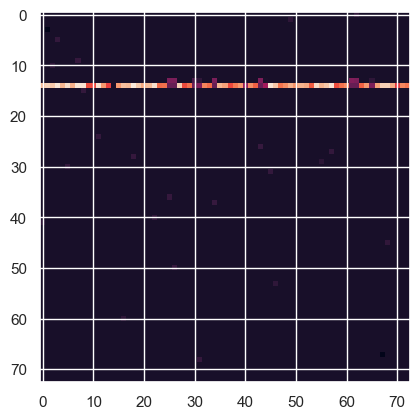

In [33]:
np.random.seed(2024)
ld = 1
H = distance_laplace(HR_Distance)
E = distance_laplace(EDA_Distance)
obj2 = lambda AE, AH, X : (1/H.shape[0] ** 2) * (0.5 * np.linalg.norm(E - AE@X, 'fro') ** 2 +  0.5 * np.linalg.norm(H - AH@X, 'fro') ** 2  + ld*np.sum(np.abs(X)))
obj = lambda A,X, Y :0.5*np.linalg.norm(Y-A@X,'fro')**2+ld*np.sum(np.abs(X))
out = np.empty(100)


Ae, Ah, X, out = DL_2(E, H,  np.random.rand(E.shape[0], E.shape[1]), lam=ld, fun = obj2, niter=100)
print(np.linalg.matrix_rank(X))

E_solo, X_E_Solo, out = DL(E, np.random.rand(E.shape[0], E.shape[1]), lam = ld, fun = obj ,niter=100)
H_solo, X_H_Solo, out = DL(H, np.random.rand(H.shape[0], H.shape[1]), lam = ld, fun = obj ,niter=100)
print(FOTS(Ae, Ah))
print(LoCo(Ae, E_solo))
print(LoCo(Ah, H_solo))
plt.imshow(X)
plt.savefig("X_DistanceFull.png")

In [34]:
print(LoCo(Ae, Ah))

1.0000000000000004


In [36]:
np.random.seed(2024)
ld = 1
H = distance_laplace(HR_Distance, scale_up = 2)
E = distance_laplace(EDA_Distance, scale_up = 2)
obj2 = lambda AE, AH, X : (1/H.shape[0] ** 2) * (0.5 * np.linalg.norm(E - AE@X, 'fro') ** 2 +  0.5 * np.linalg.norm(H - AH@X, 'fro') ** 2  + ld*np.sum(np.abs(X)))
obj = lambda A,X, Y :0.5*np.linalg.norm(Y-A@X,'fro')**2+ld*np.sum(np.abs(X))
out = np.empty(100)


Ae, Ah, X, out = DL_2(E, H,  np.random.rand(E.shape[0], E.shape[1]), lam=ld, fun = obj2, niter=100)
print(np.linalg.matrix_rank(X))

E_solo, X_E_Solo, out = DL(E, np.random.rand(E.shape[0], E.shape[1]), lam = ld, fun = obj ,niter=100)
H_solo, X_H_Solo, out = DL(H, np.random.rand(H.shape[0], H.shape[1]), lam = ld, fun = obj ,niter=100)
print(LoCo(Ae, Ah))

0.9999245790016659
0.016228980768918704
0.03779957459683237
0.08970488188389383
0.13706273697971916
0.1281170394482077
0.12484123722112125
0.13682603857979123
0.136033255745784
0.12826239691297797
0.11672498346842225
0.111237914862196
0.09735622034022692
0.0749800793915388
0.0441270508725433
0.03836708472537739
0.037291293144560186
0.024629941423124947
0.020312139782100253
0.023193121644764152
0.0260964688870468
0.027788856110745733
0.020807748684568726
0.005645554295803239
0.0005333501409236033
70
1.0000000000000016


In [27]:
np.random.seed(2024)
ld = 1
H = distance_laplace(HR_Distance, smooth_out = 2)
E = distance_laplace(EDA_Distance, smooth_out = 2)
obj2 = lambda AE, AH, X : (1/H.shape[0] ** 2) * (0.5 * np.linalg.norm(E - AE@X, 'fro') ** 2 +  0.5 * np.linalg.norm(H - AH@X, 'fro') ** 2  + ld*np.sum(np.abs(X)))
obj = lambda A,X, Y :0.5*np.linalg.norm(Y-A@X,'fro')**2+ld*np.sum(np.abs(X))
out = np.empty(100)


Ae, Ah, X, out = DL_2(E, H,  np.random.rand(E.shape[0], E.shape[1]), lam=ld, fun = obj2, niter=100)
print(np.linalg.matrix_rank(X))

E_solo, X_E_Solo, out = DL(E, np.random.rand(E.shape[0], E.shape[1]), lam = ld, fun = obj ,niter=100)
H_solo, X_H_Solo, out = DL(H, np.random.rand(H.shape[0], H.shape[1]), lam = ld, fun = obj ,niter=100)

0.9999575518030064
0.03758405438030947
0.15530079784502265
0.18568359553001731
0.17871955194380804
0.19720156609353603
0.1910324018927052
0.1687196081245432
0.11913159389762833
0.024543649937503742
0.014511131629550263
0.017026389348758525
0.01985540785636592
0.022964498734582922
0.02579993700933475
0.030339861146965335
0.03569988463924503
0.03492419100802638
0.011208617176434682
0.00022920128823234368
31


In [28]:
np.random.seed(2024)
ld = 1
H = distance_laplace(HR_Distance, smooth_out = .5)
E = distance_laplace(EDA_Distance, smooth_out = .5)
obj2 = lambda AE, AH, X : (1/H.shape[0] ** 2) * (0.5 * np.linalg.norm(E - AE@X, 'fro') ** 2 +  0.5 * np.linalg.norm(H - AH@X, 'fro') ** 2  + ld*np.sum(np.abs(X)))
obj = lambda A,X, Y :0.5*np.linalg.norm(Y-A@X,'fro')**2+ld*np.sum(np.abs(X))
out = np.empty(100)


Ae, Ah, X, out = DL_2(E, H,  np.random.rand(E.shape[0], E.shape[1]), lam=ld, fun = obj2, niter=100)
print(np.linalg.matrix_rank(X))

E_solo, X_E_Solo, out = DL(E, np.random.rand(E.shape[0], E.shape[1]), lam = ld, fun = obj ,niter=100)
H_solo, X_H_Solo, out = DL(H, np.random.rand(H.shape[0], H.shape[1]), lam = ld, fun = obj ,niter=100)

0.9999875428468636
0.17583466326435368
0.3845352599724837
0.22507498001085643
0.12045039835466807
0.041834689837217755
0.006576781444646833
0.0002719507182079076
30


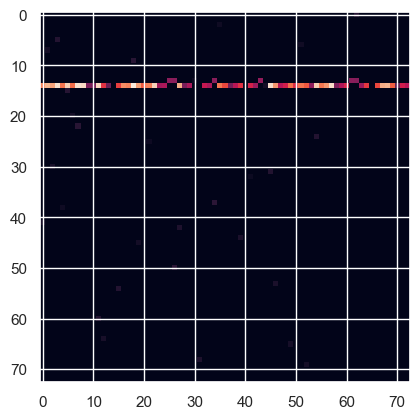

In [31]:
plt.imshow(X)

# Windowed Dictionary Learning

In [58]:
ld = .00001
avg_fots = 0
avg_loco_e = 0
avg_loco_h = 0
avg_rank = 0
for i in range(15):
    i = 6
    H = HR_Distance_Windows[i,:,:]
    E = EDA_Distance_Windows[i,:,:]
    Ae, Ah, X, out = DL_2(E, H,  np.random.rand(E.shape[0], E.shape[1]), lam=ld, fun = obj2, niter=1000)
    rank = np.linalg.matrix_rank(X)
    
    E_solo, X_E_Solo, out = DL(E, np.random.rand(E.shape[0], E.shape[1]), lam = ld, fun = obj ,niter=1000)
    H_solo, X_H_Solo, out = DL(H, np.random.rand(H.shape[0], H.shape[1]), lam = ld, fun = obj ,niter=1000)
    avg_rank = avg_rank + rank
    avg_fots = avg_fots + FOTS(Ae, Ah)
    avg_loco_e = avg_loco_e + LoCo(Ae, E_solo)
    avg_loco_h = avg_loco_h + LoCo(Ah, H_solo)
    #print(i)

print("Avg FOTS" + str(avg_fots/15))
print("Avg LoCoE" + str(avg_loco_e/15))
print("Avg LoCoH" + str(avg_loco_h/15))
print("Avg Rank" + str(rank/15))

0.17002847962439463
0.00024114147873678394
0.1699753084258049
0.00030516667183964457
0.16999561778158367
0.0002807434040334349
0.16998512776465485
0.000293337375886243
0.16999687940810382
0.0002792252794016028
0.17001044743812727
0.00026284930882237333
0.17007718634898375
0.00018251641710433775
0.1700150744104405
0.00025727367677520687
0.17001778215658506
0.0002540156817666934
0.1700575700041638
0.0002061035722715357
0.16994476266242273
0.0003419748363218547
0.16999764443486928
0.0002782865947554959
0.16996173007191193
0.0003215458428887724
0.17000975656046066
0.00026370142040289324
0.1699216864191523
0.00036973656213622555
Avg FOTS10.369188002084538
Avg LoCoE1.0
Avg LoCoH1.0
Avg Rank4.6


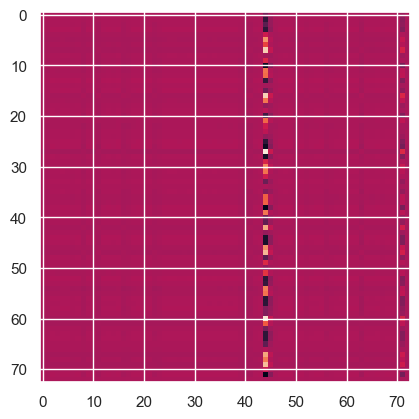

In [59]:
plt.imshow(X)

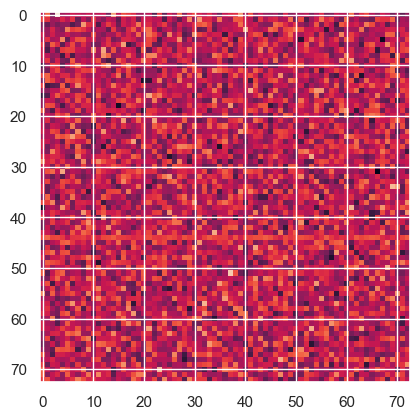

In [60]:
plt.imshow(Ae)

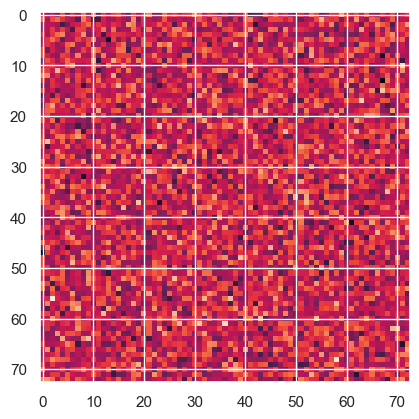

In [61]:
plt.imshow(Ah)